In [1]:
# importando as bibliotecas

import numpy as np
import sympy as sym
import control as ct
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# 1  Modelagem do sistema

In [2]:
# Parâmetros 

m = 1     # kilograma
m1 = 1    # kilograma
m2 = 1    # kilograma
l1 = 0.05 # metros
l2 = 0.05 # metros
g = 9.81  # m/s^2
f0 = 0.01
f1 = 0.007
f2 = 0.007
J1 = 0.00083 
J2 = 0.00083
Ts = 0.01
l = 0.45

# Simplificação
A01 =J1*J2*(m+m1+m2)+J1*l2*l2*m2*(m + m1)+J2*l1*l1*(m*m1+4*m*m2+m1*m2)
A02 = m*l1*l1*l2*l2*m1*m2
A0 = A01 + A02

A1 = g*l1*(m1+2*m2)
A2 = g*l2*m2

A3 = -J2*l1*(m1+2*m2)-l1*l2*l2*m1*m2
A4 = J2*(m+m1+m2)+m*l2*l2*m2 + l2*l2*m1*m2
A5 = -l1*l2*m2*(2*m+m1)

A6 = -l2*m2*(J1-l1*l1*m1)
A7 = -l1*l2*m2*(2*m+m1)
A8 = J1*(m+m1+m2)+l1*l1*m2*(m*m1 +4*m +m1)

B1 = J1*(J2 +l2*l2*m2) + J2*(l1*l1*m1+4*l1*l1*m2)+l1*l1*l2*l2*m1*m2
B2 = -J2*l1*m1-2*J2*l1*m2-l1*l2*l2*m1*m2
B3 = -J1*l2*m2+l1*l1*l2*m1*m2

# Matrizes de estado
A=np.array([[0, 0, 0, 1, 0, 0 ],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1],
            [0, -(A1*A3)/A0, -(A2*A6)/A0, 0, 0, 0],[0, -(A1*A4)/A0,-(A2*A7)/A0, 0, 0, 0],[0, -(A1*A5)/A0,-(A2*A8)/A0, 0, 0, 0]])
B=np.array([[0],[0],[0],[B1/A0],[B2/A0],[B3/A0]])
C=np.array([[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
D=0

sys = ct.ss(A,B,C,D)




In [3]:
# Discretizando a planta
sys_discreto = ct.c2d(sys, Ts, method='zoh')
Ad = np.array(sys_discreto.A)
Bd = np.array(sys_discreto.B)

In [4]:
print(sys)

<StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[   0.            0.            0.            1.            0.
         0.        ]
     [   0.            0.            0.            0.            1.
         0.        ]
     [   0.            0.            0.            0.            0.
         1.        ]
     [   0.           14.73466591   -1.64374696    0.            0.
         0.        ]
     [   0.         -442.33526109  147.64194295    0.            0.
         0.        ]
     [   0.          442.92582886 -344.30101097    0.            0.
         0.        ]]

B = [[  0.        ]
     [  0.        ]
     [  0.        ]
     [  0.77814879]
     [-10.01336453]
     [  3.35116609]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0.]]

D = [[0.]
     [0.]
     [0.]]



# 2 LQR


In [42]:
# Escolhendo Q e R
""" Cenário 1: O controle é barato (menos custo)
    Cenário 2: O controle é caro (maior custo)
    Cenário 3: Ignora o valor que custa a posição, preocupação é a posicao do pendulo(despreocupado com custos)
"""
cenario =1

if cenario == 1:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([0.01])
        
elif cenario == 2:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([1000])
        
elif cenario == 3:
        Q = np.array([[1,0,0,0,0,0],[0,10,0,0,0,0],[0,0,10,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([10])
elif cenario == 4:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
        R = np.array([1])
else:
        print('Método desconhecido')
        


#[K,S,E] = ct.lqr(A,B,Q,R)
[K,S,E] = ct.dlqr(Ad,Bd,Q,R)


In [43]:
print('Os ganhos K do Controlador são: ',K)

Os ganhos K do Controlador são:  [[  5.43344757 -88.68014468  74.76388668   8.80559964  -7.45540005
   -1.44779371]]


In [44]:
#controlador Lqr discreto
Ac = Ad - Bd @ K
Bc = Bd
Cc =  np.eye(6)
Dc = np.zeros_like(Bc)
Wip = ct.ss(Ac, Bc, Cc, Dc,Ts)

In [45]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz de controlabilidade: 6


Matrix([
[  3.88437813038502e-5, 0.000115772863622379, 0.000190466742827359, 0.000261566913824604, 0.000327903743276531, 0.000388555438773389],
[-0.000498620710872838, -0.00147149101297509, -0.00237272557931563, -0.00315939801542793, -0.00379550293804701, -0.00425409579994399],
[ 0.000165235254387502, 0.000468101221582499, 0.000690172168305373,  0.00078417921680752, 0.000712284217549139, 0.000448961073428659],
[  0.00775604725906874,  0.00760502602835415,  0.00731098925527181,  0.00688945190513186,  0.00636247735163702,  0.00575731388628023],
[   -0.099315471360343,  -0.0944660337075228,  -0.0850610952510404,  -0.0716697030327761,  -0.0550995812134601,   -0.036345452776279],
[   0.0325835785369049,   0.0270965394213194,   0.0165239304368125,   0.0016419947904163,   -0.016449897457841,   -0.036402474847977]])

In [46]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cc)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                    0,                     0,    0,                    0,                     0],
[  0,                  1.0,                     0,    0,                    0,                     0],
[  0,                    0,                   1.0,    0,                    0,                     0],
[  0,                    0,                     0,  1.0,                    0,                     0],
[  0,                    0,                     0,    0,                  1.0,                     0],
[  0,                    0,                     0,    0,                    0,                   1.0],
[1.0, 0.000733720376049382,  -8.10478922770698e-5, 0.01,  2.44974831146228e-6,  -2.71677320385037e-7],
[  0,    0.977991778268197,   0.00733381421081525,    0,  0.00992649467136372,   2.45103624070375e-5],
[  0,   0.0220014426324458,     0.982861430904178,    0,  7.35310872211125e-5,   0.00994276955200199],
[  0,    0.146142716106745,   -0.0159822452723519,  1.0, 0.00073

In [47]:
# Polos do sistema
polos = ct.poles(Wip)
zeros_s = ct.zeros(Wip)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

Os polos do sistema são:  [0.38609734+0.j         0.88419939+0.15201716j 0.88419939-0.15201716j
 0.9796651 +0.01591216j 0.9796651 -0.01591216j 0.98953874+0.j        ] Os zeros do sistema são:  []


(array([0.38609734+0.j        , 0.88419939+0.15201716j,
        0.88419939-0.15201716j, 0.9796651 +0.01591216j,
        0.9796651 -0.01591216j, 0.98953874+0.j        ]),
 array([], dtype=float64))

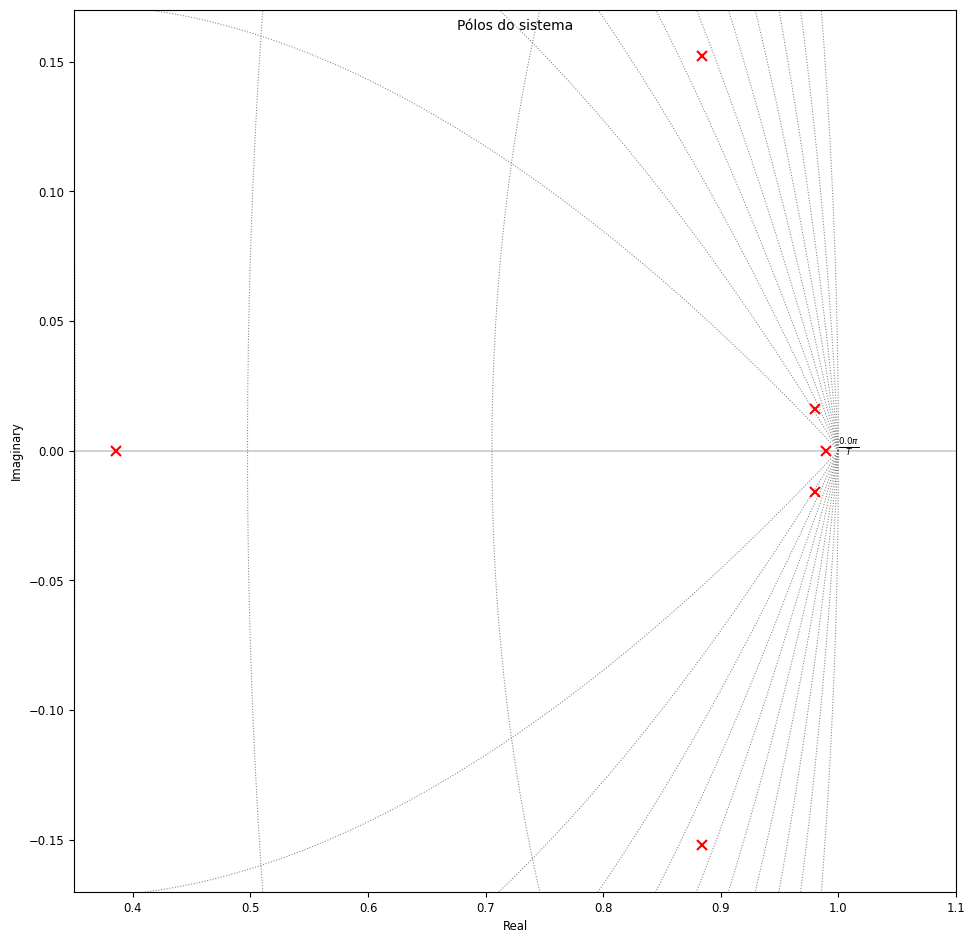

In [70]:
# Pólos do sistema
plt.figure(figsize=(9, 9)) 
ct.pzmap(Wip ,plot=True,title ='Pólos do sistema',grid=True,marker_color='r',marker_size=7,xlim=[0.35,1.1],ylim=[-0.17,0.17],scaling=True)

# 3 LQE (Kalman filtro)

In [5]:
Cf = np.array([1,0,0,0,0,0])
print(Cf)

[1 0 0 0 0 0]


In [34]:
# Sistema aumentado com pertubações e ruidos

Vd = 0.1*np.eye(6) # covariância de pertubação
Vn = 1 # covariância de ruido


Bf = np.hstack((B, Vd, np.zeros_like(B))) # entradas aumentdas com pertubação e ruido

SysC = ct.ss(A, Bf, Cf, np.array([0,0,0,0,0,0,0, Vn]))
SysFullOutput = ct.ss(A,Bf, np.eye(6),np.zeros([6,np.size(Bf,1)]))

In [55]:
# Construindo Kalman Filter
[Kf,_,_ ]= ct.lqe(A,Vd,Cf,Vd,Vn)

sysKF = ct.ss(A-Kf * Cf, np.array([B, Kf]), np.eye(6), np.zeros_like(np.array([B, Kf])))

ValueError: state-space matrix must be 2-dimensional

In [49]:
np.zeros_like(np.array([B, Kf]))

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

# Simulações

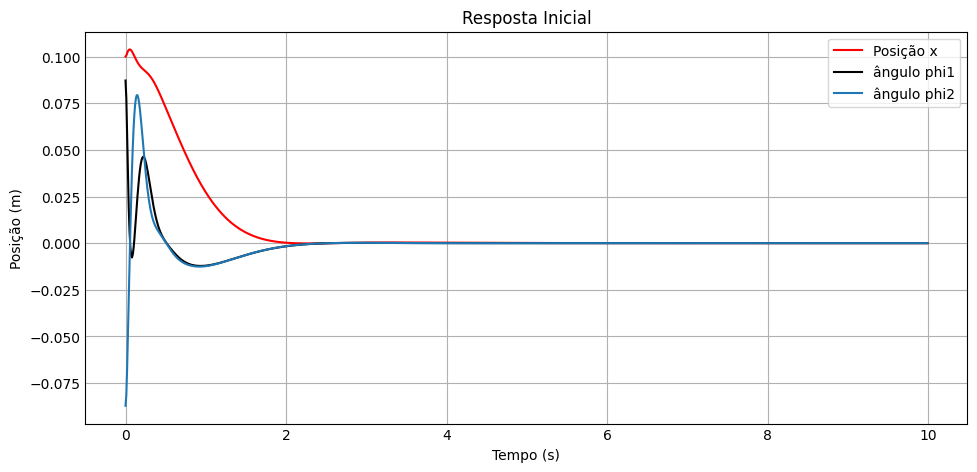

In [49]:
# Simulação 1

# Condições iniciais:
"""
Posição angular inicial de (5°) para ambos os pêndulos e posicão inicial
nula para o carro
"""

x0 = np.array([[0.1],[0.0872],[-0.0872],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 10, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)


altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0],'-r', label='Posição x')
subplots[1].plot(t,y[1], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(t,y[2], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

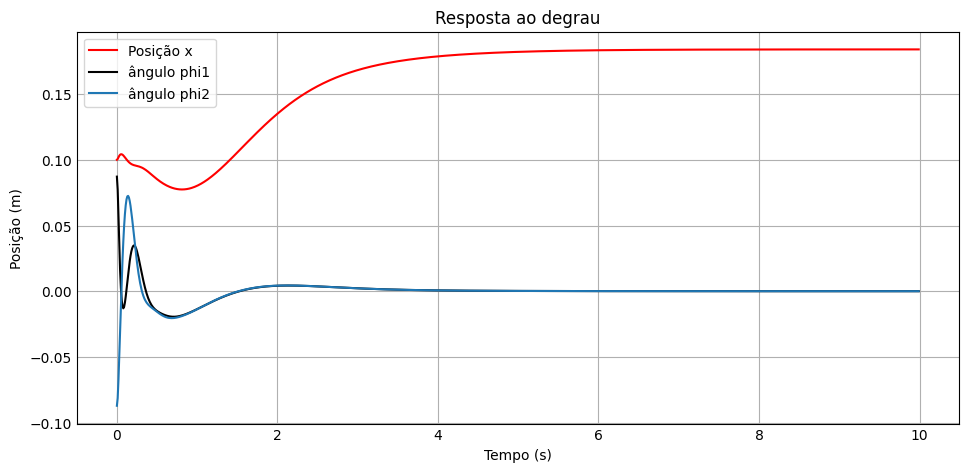

In [50]:
s,p = ct.step_response(Wip,T=t,X0=x0)

altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(s,p[0][0],'-r', label='Posição x')
subplots[1].plot(s,p[1][0], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(s,p[2][0], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta ao degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

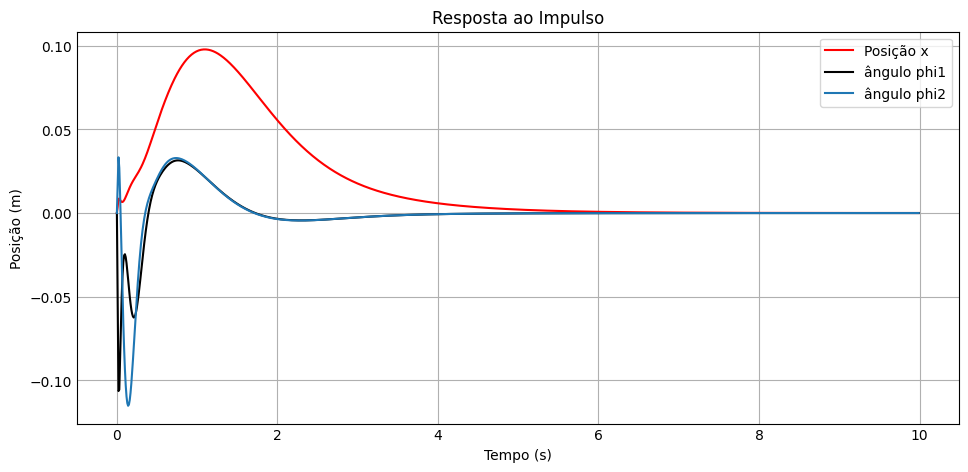

In [51]:
i,r = ct.impulse_response(Wip,T=t)
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(i,r[0][0],'-r', label='Posição x')
subplots[1].plot(i,r[1][0], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(i,r[2][0], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta ao Impulso')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

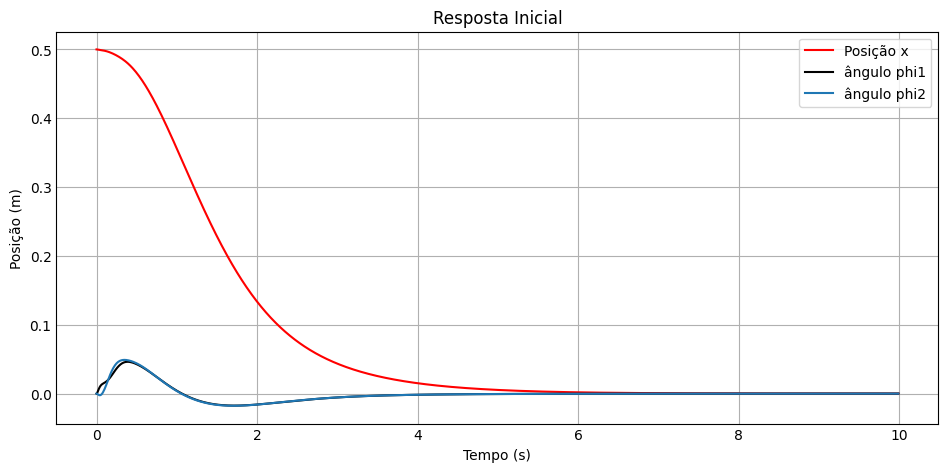

In [52]:
# Simulação 2

# Condições iniciais:
"""
Posição angular inicial nula para ambos os pêndulos e posicão inicial
em x = 0.5 m para o carro
"""

x0 = np.array([[0.5],[0.0],[0.0],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 10, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)
s,p = ct.step_response(Wip,T=t,X0=x0)

altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0],'-r', label='Posição x')
subplots[1].plot(t,y[1], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(t,y[2], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

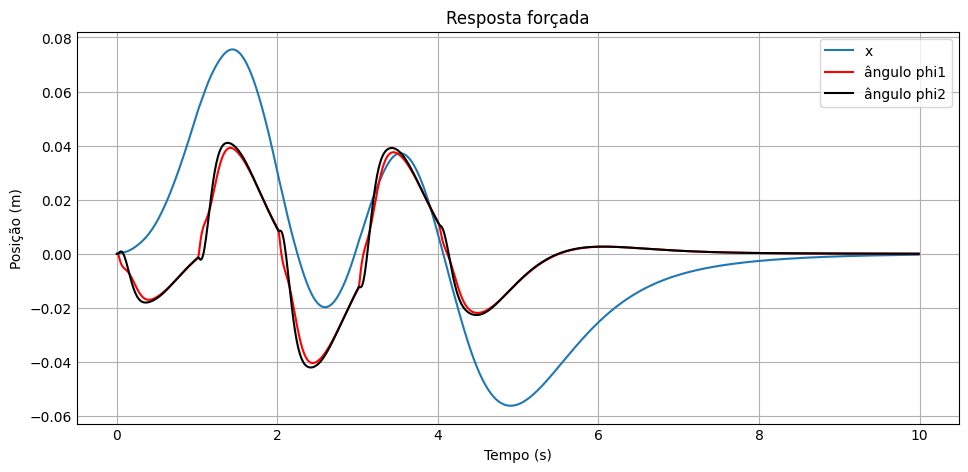

In [53]:
# Simulação 3

# Aplicando entrada 

# Definindo a função de entrada personalizada
def input_signal(t, t_entrada_apply, amplitude_pert):
    if t> 0 and t<=1:
        sinal_entrada = 1
    elif t> 1 and t<=2:
        sinal_entrada = -1
    elif t> 2 and t<=3:
        sinal_entrada =1
    elif t>3 and t<=4:
        sinal_entrada=-1
    else:
        sinal_entrada = 0
        
    return sinal_entrada

# Instante de tempo em que a entrada será aplicada
t_entrada_apply = 2

# Amplitude da entrada
amplitude_pert =0.2


# Aplicando a entrada
u = [input_signal(t_i, t_entrada_apply, amplitude_pert) for t_i in t]
#u = np.square(np.sin(2*np.pi*t))
#u = 8
# Calculando a resposta do sistema com a entrada aplicada
#t_out, y_out, w_out = ct.forced_response(Wip, T=t, U=u)
#t_out, y_out= ct.forced_response(Wip, T=t, U=u)
t_out, y_out= ct.input_output_response(Wip,t,U=u)
# Plotando a saída
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t_out, y_out[0],label='x')
subplots[1].plot(t_out, y_out[1],'-r', label='ângulo phi1')
subplots[1].plot(t_out, y_out[2],'-k',label='ângulo phi2')
subplots[1].set_title('Resposta forçada')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()